<a href="https://colab.research.google.com/github/zyf2021/-/blob/main/FCN_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предобученная модель

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:04<00:00, 47.9MB/s]


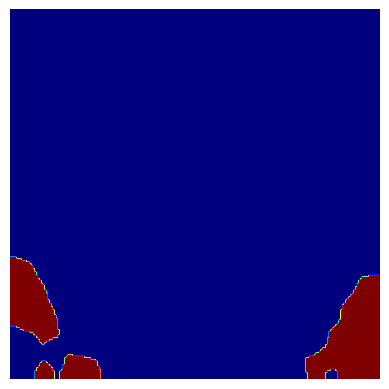

In [ ]:
import torch
import torchvision.models.segmentation as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка предварительно обученной модели FCN
fcn_model = models.fcn_resnet101(pretrained=True)

# Переключение модели в режим оценки (evaluation mode)
fcn_model.eval()

# Преобразование входного изображения
transform = transforms.Compose([
    transforms.Resize(256),  # Масштабирование изображения до 256x256
    transforms.CenterCrop(224),  # Обрезка изображения до размера 224x224
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация значений пикселей
])

# Загрузка и обработка входного изображения
image_path = 'apple.jpg'
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)  # Добавление размерности пакета

# Подача изображения на вход модели
with torch.no_grad():
    output = fcn_model(input_tensor)['out']

# Получение маски сегментации
segmentation_mask = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()

# Визуализация маски сегментации
plt.imshow(segmentation_mask, cmap='jet')
plt.axis('off')
plt.show()


In [ ]:
!unzip '/content/drive/MyDrive/building_damages.zip' -d "/content/drive/MyDrive/building_damages"

In [ ]:
# Путь к папке с изображениями и масками
train_folder = '/content/drive/MyDrive/building_damages/valid'

# Получение списка файлов в папке train
files = os.listdir(train_folder)
print(files)

# Фильтрация файлов по расширению
image_files = [file for file in files if file.endswith('.jpg')]
mask_files = [file for file in files if file.endswith('_mask.png')]
print(image_files)
print(mask_files)

# Создание папок image и mask, если они не существуют
image_folder = os.path.join(train_folder, 'image')
mask_folder = os.path.join(train_folder, 'mask')
os.makedirs(image_folder, exist_ok=True)
os.makedirs(mask_folder, exist_ok=True)


for image_file in image_files:
  src_image = os.path.join(train_folder, image_file)
  dst_image = os.path.join(image_folder, image_file)
  shutil.move(src_image, dst_image)


for mask_file in mask_files:
  src_mask = os.path.join(train_folder, mask_file)
  dst_mask = os.path.join(mask_folder, mask_file)
  shutil.move(src_mask, dst_mask)

['-157955495_jpg.rf.4f70998ae6f955311eb9a1a13850ec49.jpg', '-157955495_jpg.rf.4f70998ae6f955311eb9a1a13850ec49_mask.png', '-2_jpg.rf.662a31f945f2a313131da1f11ecb920d.jpg', '-2_jpg.rf.662a31f945f2a313131da1f11ecb920d_mask.png', '13_jpg.rf.cd1e4090dd26d9f5c982a26bc5524b6d.jpg', '13_jpg.rf.cd1e4090dd26d9f5c982a26bc5524b6d_mask.png', '1627117939_24-kartinkin-com-p-kirpich-so-shtukaturkoi-tekstura-krasivo-33_jpg.rf.67b210ff329b2a38c1db4590b3d404df.jpg', '1627117939_24-kartinkin-com-p-kirpich-so-shtukaturkoi-tekstura-krasivo-33_jpg.rf.67b210ff329b2a38c1db4590b3d404df_mask.png', '1628cf09c04849160cf1fec290921ff6_jpeg.rf.4733ee6541c5d652e6279f4dbf4428b9.jpg', '1628cf09c04849160cf1fec290921ff6_jpeg.rf.4733ee6541c5d652e6279f4dbf4428b9_mask.png', '1639796818_30-pro-dachnikov-com-p-foto-starinnoi-kladki-34_jpg.rf.b163455a12070202c585c97a03e96bac.jpg', '1639796818_30-pro-dachnikov-com-p-foto-starinnoi-kladki-34_jpg.rf.b163455a12070202c585c97a03e96bac_mask.png', '21024_jpg.rf.e480d1c7a968f32fa425ad1

# Модель на обучение

In [1]:
from google.colab import drive
import os
import shutil
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '_mask.png'))

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        mask = mask.squeeze() # чтобы [640, 640], а не [1, 640, 640]
        return image, mask

In [3]:
# Пример использования класса Dataset для сегментации
train_img_dir = '/content/drive/MyDrive/building_damages/train/image'
train_mask_dir = '/content/drive/MyDrive/building_damages/train/mask'

valid_img_dir = '/content/drive/MyDrive/building_damages/valid/image'
valid_mask_dir = '/content/drive/MyDrive/building_damages/valid/mask'

test_img_dir = '/content/drive/MyDrive/building_damages/test/image'
test_mask_dir = '/content/drive/MyDrive/building_damages/test/mask'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_segmentation_dataset = SegmentationDataset(train_img_dir, train_mask_dir, transform=transform)
valid_segmentation_dataset = SegmentationDataset(valid_img_dir, valid_mask_dir, transform=transform)
test_segmentation_dataset = SegmentationDataset(test_img_dir, test_mask_dir, transform=transform)

In [4]:
from torch.utils.data import DataLoader
# Параметры загрузчика данных
batch_size = 4

# Создание экземпляра класса DataLoader
train_data_loader = DataLoader(train_segmentation_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(valid_segmentation_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_segmentation_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# for batch, (images, masks) in enumerate(train_data_loader):
        # print(batch, images.shape, masks.shape)

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Определение модели
num_classes = 8  # Замените на количество классов в вашем наборе данных
model = maskrcnn_resnet50_fpn_v2(weights=False, num_classes=num_classes).to(device)

# Определение функции потерь и оптимизатора
criterion = CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    loss = 0.0
    for batch_idx, (images, masks) in enumerate(train_data_loader):
        images, masks = images.float().to(device), masks.float().to(device=device).long()  # Перемещение данных на GPU
        # print(masks.shape)
        optimizer.zero_grad()
        # outputs = model(images)
        # print(masks, outputs)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    loss /= len(train_data_loader)
    # Оценка производительности модели на валидационном наборе данных
    model.eval()
    val_loss = 0.0
    for batch_idx, (images, masks) in enumerate(valid_data_loader):
        with torch.no_grad():
            images, masks = images.float().to(device), masks.float().to(device=device).long()  # Перемещение данных на GPU
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
    val_loss /= len(valid_data_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

# Сохранение обученной модели
torch.save(model.state_dict(), 'fcn_model.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AssertionError: targets should not be none when in training mode

In [17]:
import matplotlib.pyplot as plt

torch.Size([4, 8, 256, 256])


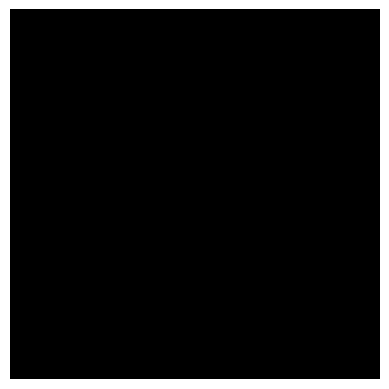

torch.Size([4, 8, 256, 256])


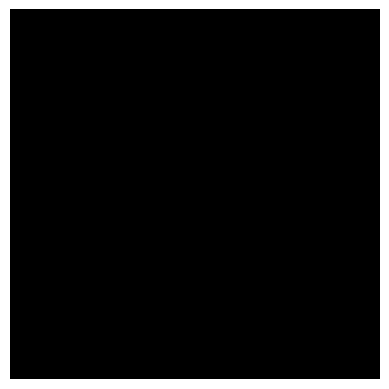

torch.Size([4, 8, 256, 256])


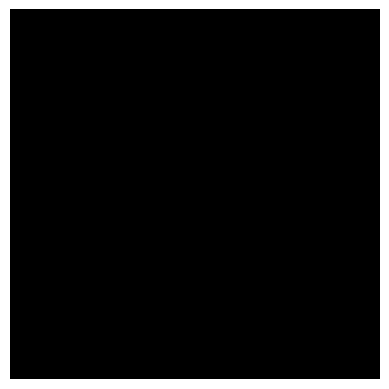

torch.Size([4, 8, 256, 256])


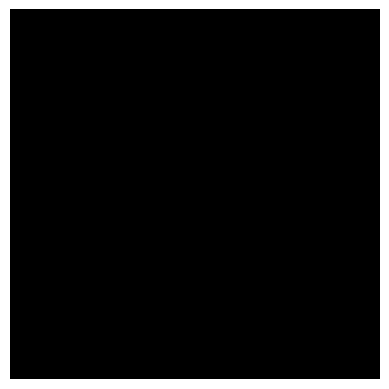

torch.Size([4, 8, 256, 256])


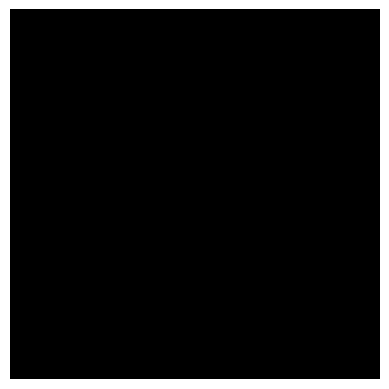

torch.Size([4, 8, 256, 256])


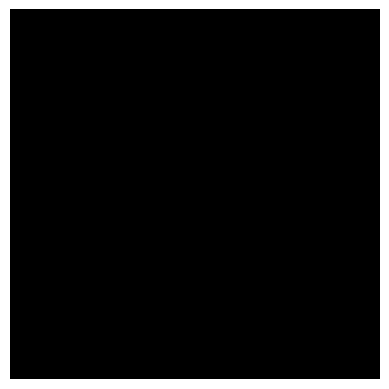

torch.Size([2, 8, 256, 256])


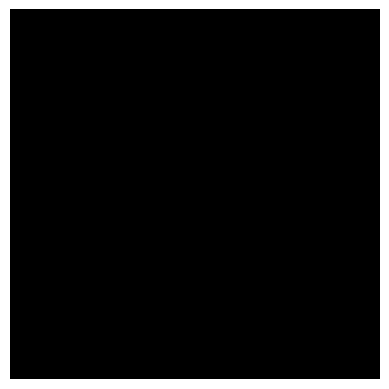

In [23]:
model.eval()

# Перебор элементов в DataLoader
for images, masks in test_data_loader:  # Пропустите метки, если они не нужны
    # Переместите данные на GPU, если это возможно
    images = images.float().to(device)

    # Получите прогнозы модели
    with torch.no_grad():  # Установите градиенты в False, так как это только оценка
        outputs = model(images)['out']
        print(outputs.shape)
        probs = torch.softmax(outputs, dim=1)
        # Выбираем класс с максимальной вероятностью для каждого пикселя
        predicted_class = torch.argmax(probs, dim=1)
        # Преобразуем предсказанные классы в бинарные маски (например, 0 для фона и 1 для объектов)
        binary_masks = (predicted_class == 1).float()  # Предположим, что класс 1 обозначает объекты
        # Выводим первую маску из пакета
        plt.imshow(binary_masks[0].to('cpu'), cmap='gray')
        plt.axis('off')
        plt.show()
